In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import Model

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

In [ ]:
!pip install --upgrade -q kaggle

!mkdir /root/.kaggle
import json
token = {
    "username": "zahidhussain909",
    "key": "39a06efd89d0f2a699143b8d3d62b216"
}

with open('/root/.kaggle/kaggle.json', 'w') as config_file:
    json.dump(token, config_file)
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d zahidhussain909/denoised-oct-balanced

100% 1.04G/1.05G [00:14<00:00, 121MB/s]
100% 1.05G/1.05G [00:14<00:00, 76.8MB/s]


In [ ]:
import zipfile
zipref=zipfile.ZipFile("/content/denoised-oct-balanced.zip",'r')
zipref.extractall()
zipref.close()

In [ ]:
from keras.models import load_model

model = load_model('/content/classify_model4.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 100)     2800      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 100)    400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 70)        63070     
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 70)       280       
 hNormalization)                                                 
                                                        

# Score-CAM with VGG16

### original image

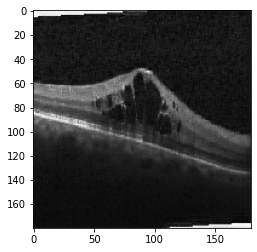

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('/content/DENOISED OCT/train/DME/1014.png'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import gc
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import json
import warnings

import numpy as np

from keras import activations
from keras import backend
from keras.utils import data_utils

# isort: off
from tensorflow.python.util.tf_export import keras_export


In [ ]:
def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    #input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    #input_shape = (180,180,3)
    input_shape = (180,180)
    #input_shape = model.layers[0].output_shape[1:]

    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))


def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

1/1 [==============================] - 0s 453ms/step


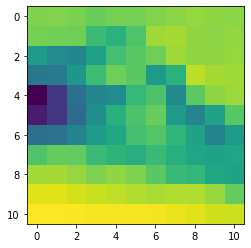

In [ ]:
#from gradcamutils import read_and_preprocess_img
import matplotlib.pyplot as plt

#model = VGG16(include_top=True, weights='imagenet')
layer_name = 'conv2d_3'
img_array = read_and_preprocess_img('/content/DENOISED OCT/train/DME/1014.png', size=(180,180))

score_cam = ScoreCam(model,img_array,layer_name)

plt.imshow(score_cam)
plt.show()

In [ ]:
fpath = data_utils.get_file(
    "/content/imagenet_class_index.json",
    '/content/imagenet_class_index.json',
)
with open(fpath) as f:
            CLASS_INDEX = json.load(f)

In [ ]:
def decode_predictions(preds, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


1/1 [==============================] - 0s 21ms/step
/content/DENOISED OCT/train/DME/1014.png
class activation map for: ('n01443537', 'DME', 1.0)
1/1 [==============================] - 0s 29ms/step


Text(0.5, 1.0, 'DME')

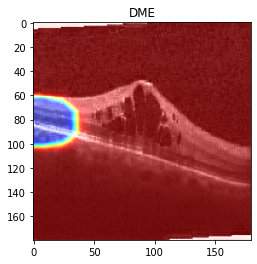

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import matplotlib.pyplot as plt
import cv2
import numpy as np

layer_name = 'conv2d_3'

img_path = '/content/DENOISED OCT/train/DME/1014.png'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(180,180))

predictions = model.predict(img_array)
top = decode_predictions(predictions, top=5)[0]
print(img_path)
print("class activation map for:",top[0])

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))

faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))


img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  # 画像の勾配を取得
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  # 太らせる処理
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

#grad_times_grad_cam = grad * grad_cam_resized
#grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

#plt.imshow(score_cam_superimposed)
plt.imshow(score_cam_emphasized)
plt.title(top[0][1])
